The following code is from [this article](https://medium.com/towards-data-science/statistical-experiments-with-resampling-cb9ad2a5e66b) in Medium.

# A/B Testing

## Data

In [1]:
import random

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

random.seed(1)

In [2]:
A_B_table = pd.read_csv("data/A_B_table.csv")

In [3]:
A_B_table

,treatment,treatment successful,treatment failed,total number of animals,% animals cured
0,new drug,2034,453,2487,81.79
1,traditional,1434,351,1785,80.34


## Permutation Test

In [4]:
def permute_values(pooled_data: pd.Series, n1: int, n2: int) -> float:
    n = n1 + n2
    idx1 = random.sample(range(n), n1)
    idx2 = list(set(range(n)) - set(idx1))
    return pooled_data.loc[idx1].mean() - pooled_data.loc[idx2].mean()

In [5]:
# new drug
n1_success = 2034
n1_fail = 453
n1_total = n1_success + n1_fail
n1_mean = n1_success / n1_total
print(
    f"new drug: treatment successful: {n1_success}, treatment failed: {n1_fail}, number of animals treated: {n1_total}, success rate: {n1_mean: .2%}"
)

new drug: treatment successful: 2034, treatment failed: 453, number of animals treated: 2487, success rate:  81.79%


In [6]:
# traditional treatment
n2_success = 1434
n2_fail = 351
n2_total = n2_success + n2_fail
n2_mean = n2_success / n2_total
print(
    f"traditional tream: treatment successful: {n2_success}, treatment failed: {n2_fail}, number of animals treated: {n2_total}, success rate: {n2_mean: .2%}"
)

traditional tream: treatment successful: 1434, treatment failed: 351, number of animals treated: 1785, success rate:  80.34%


In [7]:
# successful treatment denoted by 1 and failed treatment denoted by 0
pooled_data = pd.Series(
    [1] * n1_success + [0] * n1_fail + [1] * n2_success + [0] * n2_fail
)

In [8]:
pooled_data

0       1
1       1
2       1
3       1
4       1
       ..
4267    0
4268    0
4269    0
4270    0
4271    0
Length: 4272, dtype: int64

In [9]:
# permutation test
n_permutations = 10000
differences = []
for _ in tqdm(range(n_permutations)):
    differences.append(permute_values(pooled_data, n1=n1_total, n2=n2_total))
differences = pd.Series(differences)

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:38<00:00, 256.47it/s]


In [10]:
differences

0      -0.003792
1      -0.011491
2       0.015454
3      -0.001868
4       0.023152
          ...   
9995   -0.007642
9996    0.008718
9997   -0.005717
9998    0.009680
9999    0.009680
Length: 10000, dtype: float64

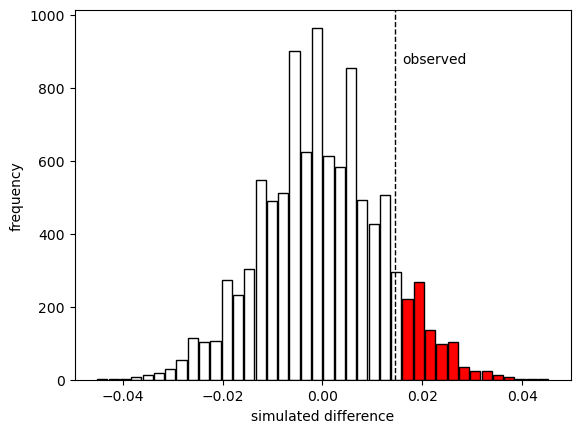

In [11]:
# plot simulated differences
fig = plt.figure()
ax = fig.subplots()
counts, bins, patches = ax.hist(differences, bins=40, rwidth=0.9, fill=True, ec="k")
for i in range(len(patches)):
    if bins[i] > n1_mean - n2_mean:
        patches[i].set_facecolor("r")
    else:
        patches[i].set_facecolor("w")
ax.axvline(x=n1_mean - n2_mean, color="k", ls="--", lw=1)
ax.text(1.1 * (n1_mean - n2_mean), 0.9 * max(counts), "observed")
plt.setp(ax, xlabel="simulated difference")
plt.setp(ax, ylabel="frequency")
plt.show();

In [12]:
# obtain the p-value
p_value = (differences > n1_mean - n2_mean).mean()
print(f"p-value is {p_value:.4f}")

p-value is 0.1084


In [13]:
# To find the difference that is sufficient to reject the null hypothesis
np.percentile(differences, 95)

0.02026537997587452

## Power Estimation

Power is the probability of detecting a given effect size for a given sample size and level of significance.

The procedure below attempts to construct a curve with the power as a function of the sample size:

- Create a synthetic dataset with animals supposed to have undergone the traditional treatment so that the treatment effectiveness is more or less what we know it to be (below, I set it to 0.8034 that corresponds to the contingency matrix above).

- Create a synthetic dataset with animals supposed to have undergone the treatment with the new drug by adding the effect size we would like to investigate (below, I set this to 0.015 and 0.020 to see its effect on the results).

- Draw a bootstrap sample of size n_sample from each synthetic dataset (below I set this to the values 3000, 4000, 5000, 6000 and 7000).

- Carry out a permutation test for statistical significance using the approach we established in the previous section and record whether the difference in treatment effectiveness is statistically significant or not.

- Keep generating bootstrap samples and compute how often the difference in treatment effectiveness is statistically significant; this is the power of the test.

This is of course a lengthier simulation and hence we limit the number of bootstrap samples to 200, whilst the number of permutations in the significance test is also reduced to 500 compared to the previous section.

In [14]:
def compute_stat_significance(
    n1_success, n1_total, n2_success, n2_total, a=0.05, n_permutations=1000
):
    """
    Computes whether the count difference is statistically significant using a permutation test
    :param n1_success: number of times the treatment is successful using the new drug
    :param n1_total: number of animals treated with the new drug
    :param n2_success: number of times the treatment is successful using the traditional treatment
    :param n2_total: number of animals treated with the traditional treatment
    :param a: significance level (default 0.05)
    :param n_permutations: number of permutations (default 1000)
    :return: True if the difference is statistically significant and False otherwise
    """
    n1_fail = n1_total - n1_success
    n1_mean = n1_success / n1_total
    n2_fail = n2_total - n2_success
    n2_mean = n2_success / n2_total

    pooled_data = pd.Series(
        [1] * n1_success + [0] * n1_fail + [1] * n2_success + [0] * n2_fail
    )
    differences = []
    for _ in range(n_permutations):
        differences.append(permute_values(pooled_data, n1=n1_total, n2=n2_total))
    differences = pd.Series(differences)
    p_value = (differences > (n1_mean - n2_mean)).mean()
    # print(
    #     f"contingency matrix: {n1_success}, {n1_total}, {n2_success}, {n2_total}, p-value is {p_value:.4f}"
    # )
    return p_value < a

In [15]:
power_results = []
for effect_size in [0.015, 0.02]:
    # hypothetical data for the traditional treatment
    n_hypothetical_data = 10_000
    traditional_treatment_effectiveness = 0.80336
    hypothetical_data2 = [1] * round(
        traditional_treatment_effectiveness * n_hypothetical_data
    )
    hypothetical_data2.extend([0] * (n_hypothetical_data - len(hypothetical_data2)))

    # hypothetical data for the new drug treatment
    new_drug_treatment_effectiveness = 0.80336 + effect_size
    hypothetical_data1 = [1] * round(
        new_drug_treatment_effectiveness * n_hypothetical_data
    )
    hypothetical_data1.extend([0] * (n_hypothetical_data - len(hypothetical_data1)))

    n_bootstrap_trials = 200

    for n_sample in tqdm(range(3_000, 8_000, 1_000)):
        # use bootstrapping to create samples
        difference_significances = []
        for _ in range(n_bootstrap_trials):
            sample1 = np.random.choice(hypothetical_data1, replace=True, size=n_sample)
            sample2 = np.random.choice(hypothetical_data2, replace=True, size=n_sample)
            difference_significances.append(
                compute_stat_significance(
                    n1_success=sum(sample1),
                    n1_total=n_sample,
                    n2_success=sum(sample2),
                    n2_total=n_sample,
                    a=0.05,
                    n_permutations=500,
                )
            )
        power_results.append(
            {
                "effect size": effect_size,
                "sample size": n_sample,
                "power": sum(difference_significances) / n_bootstrap_trials,
            }
        )
        print(power_results)

power_results = pd.DataFrame(power_results)

 20%|████████████████▌                                                                  | 1/5 [08:10<32:42, 490.50s/it]

[{'effect size': 0.015, 'sample size': 3000, 'power': 0.46}]


 40%|█████████████████████████████████▏                                                 | 2/5 [18:13<27:49, 556.49s/it]

[{'effect size': 0.015, 'sample size': 3000, 'power': 0.46}, {'effect size': 0.015, 'sample size': 4000, 'power': 0.55}]


 60%|█████████████████████████████████████████████████▊                                 | 3/5 [30:20<21:08, 634.35s/it]

[{'effect size': 0.015, 'sample size': 3000, 'power': 0.46}, {'effect size': 0.015, 'sample size': 4000, 'power': 0.55}, {'effect size': 0.015, 'sample size': 5000, 'power': 0.635}]


 80%|██████████████████████████████████████████████████████████████████▍                | 4/5 [45:40<12:27, 747.38s/it]

[{'effect size': 0.015, 'sample size': 3000, 'power': 0.46}, {'effect size': 0.015, 'sample size': 4000, 'power': 0.55}, {'effect size': 0.015, 'sample size': 5000, 'power': 0.635}, {'effect size': 0.015, 'sample size': 6000, 'power': 0.68}]


100%|█████████████████████████████████████████████████████████████████████████████████| 5/5 [1:02:27<00:00, 749.54s/it]


[{'effect size': 0.015, 'sample size': 3000, 'power': 0.46}, {'effect size': 0.015, 'sample size': 4000, 'power': 0.55}, {'effect size': 0.015, 'sample size': 5000, 'power': 0.635}, {'effect size': 0.015, 'sample size': 6000, 'power': 0.68}, {'effect size': 0.015, 'sample size': 7000, 'power': 0.695}]


 20%|████████████████▌                                                                  | 1/5 [07:44<30:59, 464.84s/it]

[{'effect size': 0.015, 'sample size': 3000, 'power': 0.46}, {'effect size': 0.015, 'sample size': 4000, 'power': 0.55}, {'effect size': 0.015, 'sample size': 5000, 'power': 0.635}, {'effect size': 0.015, 'sample size': 6000, 'power': 0.68}, {'effect size': 0.015, 'sample size': 7000, 'power': 0.695}, {'effect size': 0.02, 'sample size': 3000, 'power': 0.66}]


 40%|█████████████████████████████████▏                                                 | 2/5 [17:56<27:33, 551.30s/it]

[{'effect size': 0.015, 'sample size': 3000, 'power': 0.46}, {'effect size': 0.015, 'sample size': 4000, 'power': 0.55}, {'effect size': 0.015, 'sample size': 5000, 'power': 0.635}, {'effect size': 0.015, 'sample size': 6000, 'power': 0.68}, {'effect size': 0.015, 'sample size': 7000, 'power': 0.695}, {'effect size': 0.02, 'sample size': 3000, 'power': 0.66}, {'effect size': 0.02, 'sample size': 4000, 'power': 0.75}]


 60%|█████████████████████████████████████████████████▊                                 | 3/5 [30:36<21:33, 646.61s/it]

[{'effect size': 0.015, 'sample size': 3000, 'power': 0.46}, {'effect size': 0.015, 'sample size': 4000, 'power': 0.55}, {'effect size': 0.015, 'sample size': 5000, 'power': 0.635}, {'effect size': 0.015, 'sample size': 6000, 'power': 0.68}, {'effect size': 0.015, 'sample size': 7000, 'power': 0.695}, {'effect size': 0.02, 'sample size': 3000, 'power': 0.66}, {'effect size': 0.02, 'sample size': 4000, 'power': 0.75}, {'effect size': 0.02, 'sample size': 5000, 'power': 0.82}]


 80%|██████████████████████████████████████████████████████████████████▍                | 4/5 [44:49<12:08, 728.17s/it]

[{'effect size': 0.015, 'sample size': 3000, 'power': 0.46}, {'effect size': 0.015, 'sample size': 4000, 'power': 0.55}, {'effect size': 0.015, 'sample size': 5000, 'power': 0.635}, {'effect size': 0.015, 'sample size': 6000, 'power': 0.68}, {'effect size': 0.015, 'sample size': 7000, 'power': 0.695}, {'effect size': 0.02, 'sample size': 3000, 'power': 0.66}, {'effect size': 0.02, 'sample size': 4000, 'power': 0.75}, {'effect size': 0.02, 'sample size': 5000, 'power': 0.82}, {'effect size': 0.02, 'sample size': 6000, 'power': 0.865}]


100%|█████████████████████████████████████████████████████████████████████████████████| 5/5 [1:00:17<00:00, 723.47s/it]

[{'effect size': 0.015, 'sample size': 3000, 'power': 0.46}, {'effect size': 0.015, 'sample size': 4000, 'power': 0.55}, {'effect size': 0.015, 'sample size': 5000, 'power': 0.635}, {'effect size': 0.015, 'sample size': 6000, 'power': 0.68}, {'effect size': 0.015, 'sample size': 7000, 'power': 0.695}, {'effect size': 0.02, 'sample size': 3000, 'power': 0.66}, {'effect size': 0.02, 'sample size': 4000, 'power': 0.75}, {'effect size': 0.02, 'sample size': 5000, 'power': 0.82}, {'effect size': 0.02, 'sample size': 6000, 'power': 0.865}, {'effect size': 0.02, 'sample size': 7000, 'power': 0.935}]


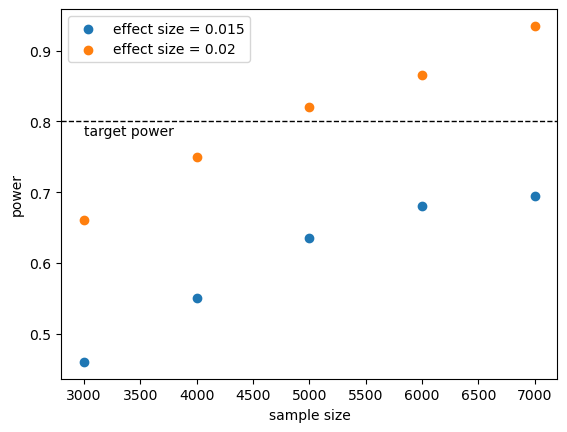

In [16]:
fig = plt.figure()
ax = fig.subplots()
ax.scatter(
    power_results.loc[power_results["effect size"] == 0.015, "sample size"],
    power_results.loc[power_results["effect size"] == 0.015, "power"],
    label="effect size = 0.015",
)
ax.scatter(
    power_results.loc[power_results["effect size"] == 0.02, "sample size"],
    power_results.loc[power_results["effect size"] == 0.02, "power"],
    label="effect size = 0.02",
)
ax.legend()
ax.axhline(y=0.8, color="k", ls="--", lw=1)
ax.text(3000, 0.78, "target power")
plt.setp(ax, xlabel="sample size")
plt.setp(ax, ylabel="power")
plt.show();

In [17]:
# With statsmodels

import statsmodels.api as sm

for effective_increase in [0.015, 0.02]:
    effect_size = sm.stats.proportion_effectsize(0.80336 + effective_increase, 0.80336)
    analysis = sm.stats.TTestIndPower()
    result = analysis.solve_power(effect_size=effect_size, alpha=0.05, power=0.8, alternative='larger')
    print(f'effect size: {effective_increase:.3f}, sample size: {result:.2f}')

effect size: 0.015, sample size: 8426.09
effect size: 0.020, sample size: 4690.38


# Concluding Throught

Before we close, a note of caution is due. This article puts much emphasis on the p-value that is increasingly being criticized. The truth is that the importance of the p-value has historically been exaggerated. The p-value indicates how incompatible the data are with a statistical model or permutation test representing the null hypothesis. The p-value is not the probability that the alternative hypothesis is true. Moreover, a p-value that shows that the null value can be rejected does not mean that the size of the effect is important. A small effect size may be statistically significant, but it is so small that this is not important.